# Comparison of the a-b meta-correlation with Yamamoto's method
- Conversion of a-b data into lines log(GH)-log(IS) space
- Meta-correlation lines in log(GH)-log(IS) space
- Comparison to Yamamoto analysis results for lysozyme on SP Sepharose FF

In [6]:
import platform
from pathlib import Path

import os
import subprocess
import time

import numpy as np
import scipy
from scipy import optimize
import pandas as pd # I added as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from addict import Dict
import json

# Temporary files for simulation objects
import tempfile
tempfile.tempdir = os.path.join(Path.home())

# IPython
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image
from ipywidgets import interact, interactive
import ipywidgets as widgets

import copy
from biopandas.pdb import PandasPdb


In [7]:
def my_fit_function_ln_keq_2(tis, a, b):
    return np.log(a*tis**b)

def ls_optimization(x, tis, Keq_exp):
    a = x[0]
    b = x[1]
    log_Keq_pred = my_fit_function_ln_keq_2(tis, a, b)
    return log_Keq_pred - np.log(Keq_exp)

def meta_correlation(a, c, d):
    return c*np.log(a) + d

# Read estimated dimensionless $K_{eq}$ data
Estimated based on fit porosities in AEX simulations and lysozyme measurements; need to correct t_extra neglect problem in mAb D data to obtain an appropriate phase ratio.


In [8]:
files_Keq_nd = os.listdir('./dimensionless_Keq_1')
files_Keq_nd.remove('AEX_fit_porosities.xlsx')
files_Keq_nd.sort()
files_Keq_nd

['caq_adh_pH_7.csv',
 'caq_blg_pH_7.csv',
 'caq_cat_pH_7.csv',
 'caq_ova_pH_7.csv',
 'phq_adh_pH_7.csv',
 'phq_blg_pH_7.csv',
 'phq_cat_pH_7.csv',
 'phq_ova_pH_7.csv',
 'pxq_adh_pH_7.csv',
 'pxq_blg_pH_7.csv',
 'pxq_cat_pH_7.csv',
 'pxq_ova_pH_7.csv',
 'sep_lys_pH_5.csv',
 'sep_lys_pH_7.csv',
 'sep_lys_pH_9.csv',
 'sep_mAbD_pH_7.csv']

In [9]:
dfs_Keq_nd = {}
for file in files_Keq_nd:
    dfs_Keq_nd[file] = pd.read_csv(f'./dimensionless_Keq_1/{file}')

In [10]:
temp = []

for file in files_Keq_nd:
    df = dfs_Keq_nd[file]
    
    fit = optimize.least_squares(ls_optimization, np.array([6.015708e+07, -3.571804]),
                        args=(df['IS (M)']*1e3, df['Keq_nd']), gtol=1e-10, ftol=1e-10)
    temp.append([file, fit.x[0], fit.x[1]])

df_Keq_nd = pd.DataFrame(temp, columns=['file', 'a', 'b'])

/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
for i, icont in df_Keq_nd.iterrows():
    f = icont['file']
    df_Keq_nd.at[i, 'resin'] = f[:f.find('_')]
    df_Keq_nd.at[i, 'protein'] = f[f.find('_')+1:f.find('_')+4]
    df_Keq_nd.at[i, 'pH'] = f[f.find('.')-1]

df_Keq_nd.sort_values(by=['resin', 'protein', 'pH'], inplace=True)
df_Keq_nd.reset_index(drop=True, inplace=True)
df_Keq_nd

,file,a,b,resin,protein,pH
0,caq_adh_pH_7.csv,3.841287e+03,-1.531318,caq,adh,7
1,caq_blg_pH_7.csv,2.050557e+16,-6.326865,caq,blg,7
2,caq_cat_pH_7.csv,1.406416e+12,-5.500367,caq,cat,7
3,caq_ova_pH_7.csv,6.133014e+12,-5.166430,caq,ova,7
4,phq_adh_pH_7.csv,3.191228e+07,-3.514624,phq,adh,7
5,phq_blg_pH_7.csv,3.639106e+18,-7.261087,phq,blg,7
6,phq_cat_pH_7.csv,1.325006e+09,-3.854670,phq,cat,7
7,phq_ova_pH_7.csv,6.850904e+10,-4.463772,phq,ova,7
8,pxq_adh_pH_7.csv,5.020306e+07,-3.571804,pxq,adh,7
9,pxq_blg_pH_7.csv,3.457469e+18,-7.181838,pxq,blg,7


In [12]:
df_Keq_nd.to_csv('dimensionless_Keq_1_correlation_params.csv', index=False)

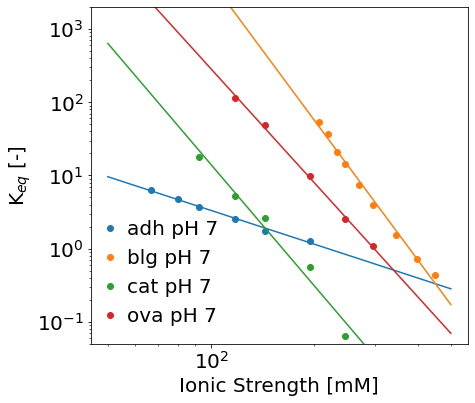

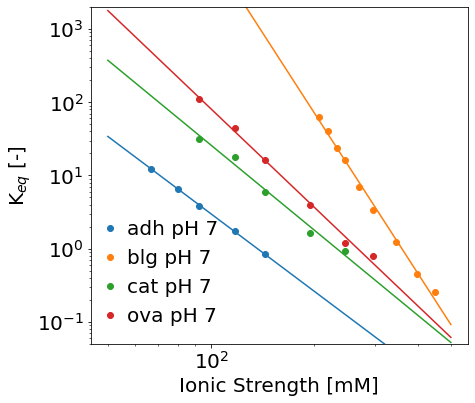

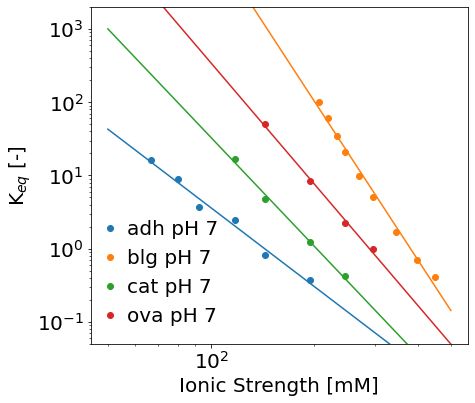

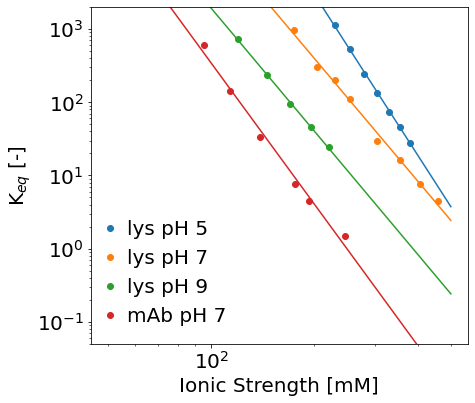

In [13]:
all_resins = ['caq', 'phq', 'pxq', 'sep']
tis_new = np.linspace(50, 500, 1000)

for res in all_resins:
    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6, forward=True)
    fig.patch.set_alpha(1.0)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ [-]')
    ax.set_ylim(5e-2, 2e3)
    
    df_params = df_Keq_nd[df_Keq_nd['resin'] == res]
    for i, icont in df_params.iterrows():
        df = dfs_Keq_nd[icont['file']]
        label = icont['protein'] + ' pH ' + icont['pH']
        ax.loglog(df['IS (M)']*1e3, df['Keq_nd'], 'o', label=label)

        a = icont['a']
        b = icont['b']
        keq_new = [np.exp(my_fit_function_ln_keq_2(tis, a, b)) for tis in tis_new]
        ax.loglog(tis_new, keq_new, color=plt.gca().lines[-1].get_color())        
        
    ax.legend(loc='lower left', frameon=False, handlelength=0.1)
    plt.tight_layout()
    fig.savefig('./images/dimensionless_Keq_1_yamamoto_comparison/' + res + '.png', 
                dpi=300)


# Fit meta-correlation parameters

In [14]:
meta_fit = optimize.curve_fit(meta_correlation, df_Keq_nd['a'], df_Keq_nd['b'], 
                             p0=(-1.0, -1.0), maxfev=10000)

In [15]:
a_vals = np.logspace(1, 22, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

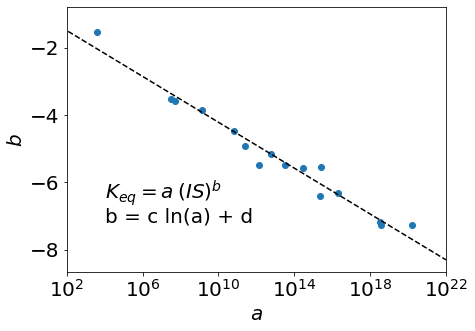

In [16]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

ax.scatter(df_Keq_nd['a'], df_Keq_nd['b'])
ax.plot(a_vals, b_vals, linestyle='--', color='black')

ax.text(x=1e4, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.text(x=1e4, y=-7.2, s='b = c ln(a) + d')

ax.set_xscale('log')
ax.set_xlim(1e2, 1e22)
plt.tight_layout()
fig.savefig('./images/dimensionless_Keq_1_yamamoto_comparison/a_vs_b.png', dpi=300)

# Convert (a, b) to Yamamoto regression parameters

In [17]:
df_Keq_nd['b_yam'] = -1.0*np.log10(df_Keq_nd['a']*(1.0 - df_Keq_nd['b']))
df_Keq_nd['m'] = -1.0*df_Keq_nd['b'] + 1.0
df_Keq_nd

,file,a,b,resin,protein,pH,b_yam,m
0,caq_adh_pH_7.csv,3.841287e+03,-1.531318,caq,adh,7,-3.987823,2.531318
1,caq_blg_pH_7.csv,2.050557e+16,-6.326865,caq,blg,7,-17.176790,7.326865
2,caq_cat_pH_7.csv,1.406416e+12,-5.500367,caq,cat,7,-12.961052,6.500367
3,caq_ova_pH_7.csv,6.133014e+12,-5.166430,caq,ova,7,-13.577708,6.166430
4,phq_adh_pH_7.csv,3.191228e+07,-3.514624,phq,adh,7,-8.158579,4.514624
5,phq_blg_pH_7.csv,3.639106e+18,-7.261087,phq,blg,7,-19.478032,8.261087
6,phq_cat_pH_7.csv,1.325006e+09,-3.854670,phq,cat,7,-9.808377,4.854670
7,phq_ova_pH_7.csv,6.850904e+10,-4.463772,phq,ova,7,-11.573240,5.463772
8,pxq_adh_pH_7.csv,5.020306e+07,-3.571804,pxq,adh,7,-8.360818,4.571804
9,pxq_blg_pH_7.csv,3.457469e+18,-7.181838,pxq,blg,7,-19.451609,8.181838


In [18]:
# Values for meta-correlation

a_vals = np.logspace(-5, 40, 46)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

data = np.array([a_vals, b_vals]).transpose()
df_meta = pd.DataFrame(data, columns=['a', 'b'])
df_meta['b_yam'] = -1.0*np.log10(df_meta['a']*(1.0 - df_meta['b']))
df_meta['m'] = -1.0*df_meta['b'] + 1.0
df_meta

,a,b,b_yam,m
0,1.000000e-05,0.891954,5.966390,0.108046
1,1.000000e-04,0.551329,4.348072,0.448671
2,1.000000e-03,0.210704,3.102760,0.789296
3,1.000000e-02,-0.129921,1.946952,1.129921
4,1.000000e-01,-0.470545,0.832522,1.470545
5,1.000000e+00,-0.811170,-0.257959,1.811170
6,1.000000e+01,-1.151795,-1.332801,2.151795
7,1.000000e+02,-1.492420,-2.396621,2.492420
8,1.000000e+03,-1.833045,-3.452253,2.833045
9,1.000000e+04,-2.173669,-4.501562,3.173669


In [19]:
is_vals = np.linspace(100, 500) # [mM]
log_is_vals = np.log10(is_vals)

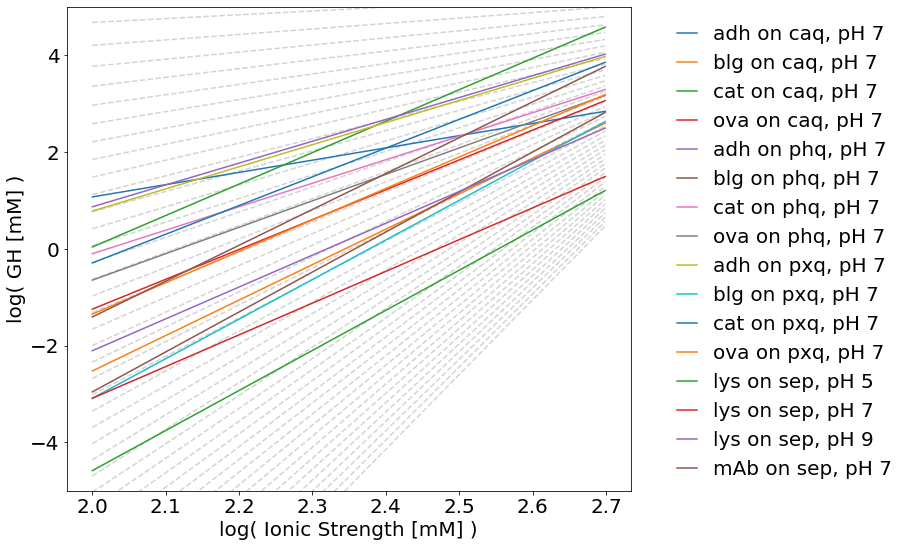

In [20]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(13, 8, forward=True)
ax.set_xlabel('log( Ionic Strength [mM] )')
ax.set_ylabel(r'log( GH [mM] )')
ax.set_ylim(-5, 5)

for i, icont in df_meta.iterrows():
    log_gh = [icont['m']*log_is + icont['b_yam'] for log_is in log_is_vals]
    ax.plot(log_is_vals, log_gh, '--', color='lightgrey')

for i, icont in df_Keq_nd.iterrows():
    log_gh = [icont['m']*log_is + icont['b_yam'] for log_is in log_is_vals]
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    label = f'{protein} on {resin}, pH {pH}'
    ax.plot(log_is_vals, log_gh, label=label)

ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
plt.tight_layout()
# fig.savefig('./images/dimensionless_Keq_1_yamamoto_comparison/logGH_logIS_all_data.png', 
#             dpi=300)

In [21]:
lys_gh_is_files = os.listdir('./lysozyme_seph_gradient_GH_results/')

dfs_grad_gh = {}
for file in lys_gh_is_files:
    dfs_grad_gh[int(file[3])] = pd.read_csv(f'./lysozyme_seph_gradient_GH_results/{file}')
    # Keys are pH values 5, 7, 9

# Compare to my gradient data for lysozmy on SP Sepharose FF

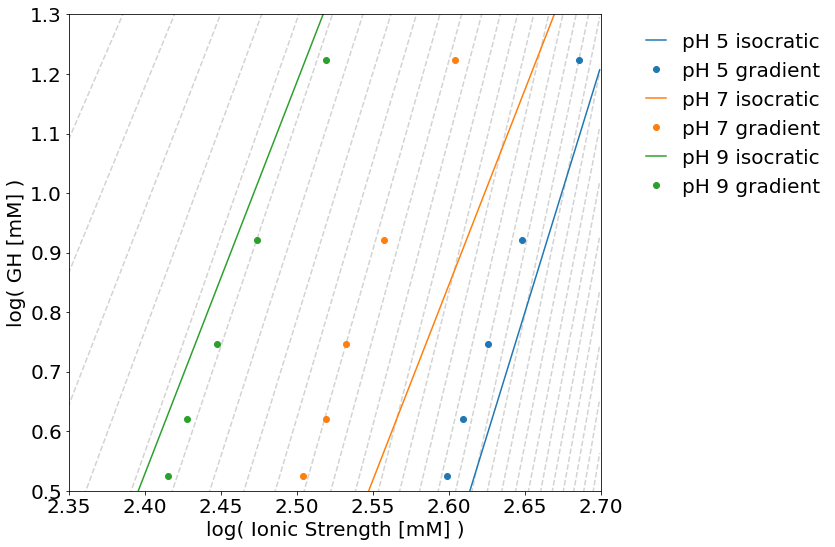

In [22]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(12, 8, forward=True)
ax.set_xlabel('log( Ionic Strength [mM] )')
ax.set_ylabel(r'log( GH [mM] )')
ax.set_ylim(0.5, 1.3)
ax.set_xlim(2.35, 2.7)


for i, icont in df_meta.iterrows():
    log_gh = [icont['m']*log_is + icont['b_yam'] for log_is in log_is_vals]
    ax.plot(log_is_vals, log_gh, '--', color='lightgrey')

for i, icont in df_Keq_nd[df_Keq_nd['protein'] == 'lys'].iterrows():
    log_gh = [icont['m']*log_is + icont['b_yam'] for log_is in log_is_vals]
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    label = f'pH {pH} isocratic'
    ax.plot(log_is_vals, log_gh, label=label)
    
    df = dfs_grad_gh[int(icont['pH'])]
    ax.plot(df['logIS'], df['logGH'], 'o', color=plt.gca().lines[-1].get_color(),
           label=f'pH {pH} gradient')

ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
plt.tight_layout()
# fig.savefig('./images/dimensionless_Keq_1_yamamoto_comparison/logGH_logIS_lys_data.png', 
#             dpi=300)

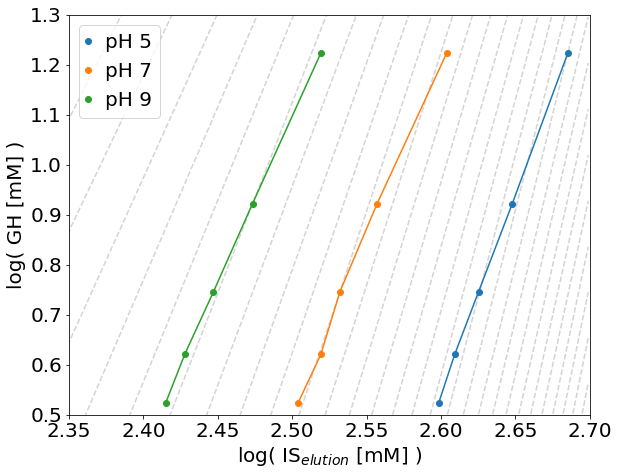

In [24]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(9, 7, forward=True)
ax.set_xlabel(r'log( IS$_{elution}$ [mM] )')
ax.set_ylabel(r'log( GH [mM] )')
ax.set_ylim(0.5, 1.3)
ax.set_xlim(2.35, 2.7)

for i, icont in df_meta.iterrows():
    log_gh = [icont['m']*log_is + icont['b_yam'] for log_is in log_is_vals]
    ax.plot(log_is_vals, log_gh, '--', color='lightgrey')

for i, icont in df_Keq_nd[df_Keq_nd['protein'] == 'lys'].iterrows():
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    
    df = dfs_grad_gh[int(icont['pH'])]
    ax.plot(df['logIS'], df['logGH'], '-o', label=f'pH {pH}')

ax.legend(loc='upper left', frameon=True, handlelength=0.1)
plt.tight_layout()
# fig.savefig('./images/dimensionless_Keq_1_yamamoto_comparison/logGH_logIS_lys_data_only_gradient_2.png', 
#             dpi=300)

In [25]:
import itertools
marker = itertools.cycle(('o', 'D', '<', 'P', '^', 's')) 

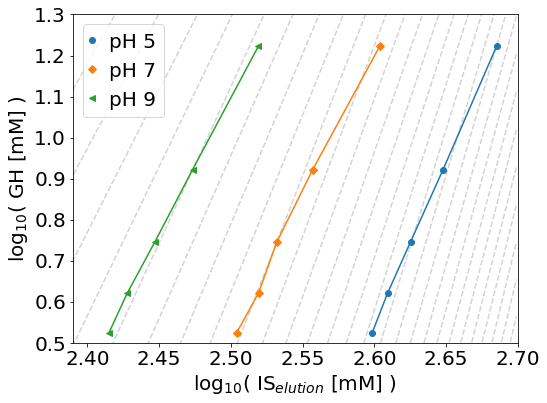

In [26]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel(r'log$_{10}$( IS$_{elution}$ [mM] )')
ax.set_ylabel(r'log$_{10}$( GH [mM] )')
ax.set_ylim(0.5, 1.3)
ax.set_xlim(2.39, 2.7)

for i, icont in df_meta.iterrows():
    log_gh = [icont['m']*log_is + icont['b_yam'] for log_is in log_is_vals]
    ax.plot(log_is_vals, log_gh, '--', color='lightgrey')

for i, icont in df_Keq_nd[df_Keq_nd['protein'] == 'lys'].iterrows():
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    
    df = dfs_grad_gh[int(icont['pH'])]    
    ax.plot(df['logIS'], df['logGH'], marker=next(marker), label=f'pH {pH}')

ax.legend(loc='upper left', frameon=True, handlelength=0.1)
plt.tight_layout()
fig.savefig('./images/manuscript_images/my_lge_data.pdf')

# Compare to data in Saleh's article

In [27]:
df_saleh = pd.read_csv('./lit_data/saleh/cleaned_data/saleh_data_mod_2.csv')

species_list = list(set(df_saleh['species']))
pH_list = list(set(df_saleh['pH']))

species_list.sort()
pH_list.sort()

species_list, pH_list

(['hmw', 'monomer'], [5.5, 5.8, 6.1])

In [28]:
factor = (1.0 - 0.41)/(1.0 - 0.73) # Conversion to my current interpretation of using 
                                    # eps_c in Yamamoto's GH - this needs to be 
                                    # REVISITED/confirmed
df_saleh['log(cs[mM])'] = np.log10(1e3*np.exp(df_saleh['ln(cs[M])']))
# df_saleh['log(GH[mM])'] = np.log10(1e3*np.exp(df_saleh['ln(GH[M])'])*factor)
df_saleh['log(GH[mM])'] = np.log10(1e3*np.exp(df_saleh['ln(GH[M])']))

df_saleh

,species,pH,ln(cs[M]),ln(GH[M]),log(cs[mM]),log(GH[mM])
0,monomer,5.5,-1.285893,-5.439437,2.441544,0.637683
1,monomer,5.5,-1.234776,-5.032012,2.463744,0.814625
2,monomer,5.5,-1.161725,-4.335557,2.495469,1.117092
3,monomer,5.8,-1.461633,-5.439437,2.365221,0.637683
4,monomer,5.8,-1.422374,-5.032012,2.382271,0.814625
5,monomer,5.8,-1.334926,-4.335557,2.420249,1.117092
6,monomer,6.1,-1.622976,-5.439437,2.295150,0.637683
7,monomer,6.1,-1.572284,-5.032012,2.317166,0.814625
8,monomer,6.1,-1.485682,-4.335557,2.354777,1.117092
9,hmw,5.5,-1.154193,-5.439437,2.498740,0.637683


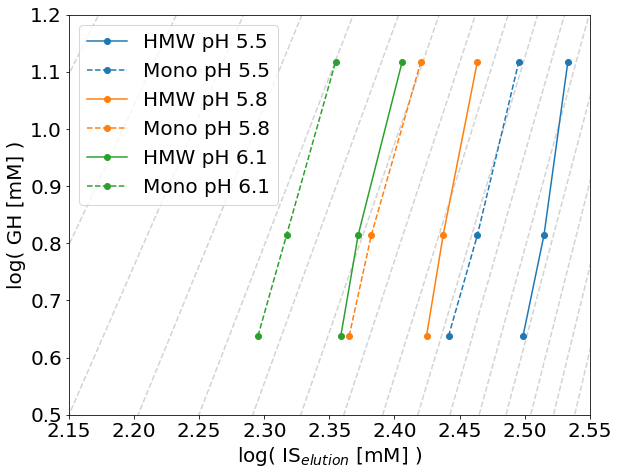

In [29]:
species_name = {'hmw':'HMW', 'monomer':'Mono'}

params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(9, 7, forward=True)
ax.set_xlabel(r'log( IS$_{elution}$ [mM] )')
ax.set_ylabel(r'log( GH [mM] )')
ax.set_ylim(0.5, 1.2) # Using data without 'factor' above
# ax.set_ylim(0.9, 1.5) # With 'factor' above
ax.set_xlim(2.15, 2.55)

for i, icont in df_meta.iterrows():
    log_gh = [icont['m']*log_is + icont['b_yam'] for log_is in log_is_vals]
    ax.plot(log_is_vals, log_gh, '--', color='lightgrey')

for pH in pH_list:
    for species in species_list:
        df = df_saleh[(df_saleh['species'] == species) & (df_saleh['pH'] == pH)]
        label=f'{species_name[species]} pH {pH}'
        
        if species == 'hmw':  
            ax.plot(df['log(cs[mM])'], df['log(GH[mM])'], '-o', label=label)
        else:
            ax.plot(df['log(cs[mM])'], df['log(GH[mM])'], '--o', label=label,
                   color=plt.gca().lines[-1].get_color())
    
ax.legend(loc='upper left', frameon=True,)
plt.tight_layout()
fig.savefig('./images/dimensionless_Keq_1_yamamoto_comparison/logGH_logIS_saleh_data.png', 
            dpi=300)

# Comparison of $(a, b)$ obtained from gradient data vs. the above fits of isocratic data

In [65]:
def ls_yamamoto_gh_is(x, log_gh, log_is):
    m = x[0]
    b = x[1]
    return log_gh - m*log_is - b

pH_vals = [5, 7, 9]
temp = []

for pH in pH_vals:
    fit = optimize.least_squares(ls_yamamoto_gh_is, np.array([1, 1]),
                        args=(dfs_grad_gh[pH]['logGH'], dfs_grad_gh[pH]['logIS']))
    m = fit.x[0]
    b = fit.x[1]
    A = 10.0**(-1.0*b)/m
    B = -1.0*(m - 1)
    temp.append([pH, A, B])
    
df_my_grad_ab = pd.DataFrame(temp, columns=['pH', 'A', 'B'])
df_my_grad_ab

,pH,A,B
0,5,2.180305e+19,-6.993300
1,7,1.935552e+16,-6.054840
2,9,5.541438e+14,-5.665758


In [66]:
temp = []

for pH in pH_list:
    for species in species_list:
        df = df_saleh[(df_saleh['species'] == species) & (df_saleh['pH'] == pH)]
        fit = optimize.least_squares(ls_yamamoto_gh_is, np.array([1, 1]),
                        args=(df['log(GH[mM])'], df['log(cs[mM])']))
        m = fit.x[0]
        b = fit.x[1]
        A = 10.0**(-1.0*b)/m
        B = -1.0*(m - 1)
        temp.append([pH, species, A, B])
        
df_saleh_ab = pd.DataFrame(temp, columns=['pH', 'species', 'A', 'B'])
df_saleh_ab

,pH,species,A,B
0,5.5,hmw,1.482861e+33,-12.982040
1,5.5,monomer,1.709139e+20,-7.934346
2,5.8,hmw,6.108992e+27,-11.174040
3,5.8,monomer,5.329393e+18,-7.587223
4,6.1,hmw,6.161070e+21,-8.938615
5,6.1,monomer,8.149163e+16,-7.040453


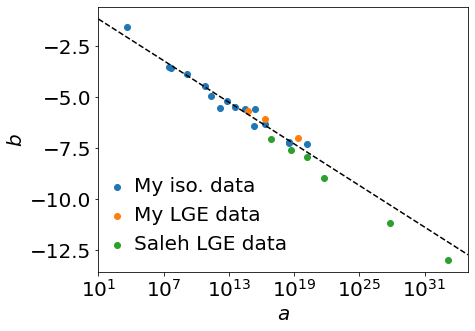

In [67]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

a_vals = np.logspace(1, 35, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]
ax.plot(a_vals, b_vals, linestyle='--', color='black')

ax.scatter(df_Keq_nd['a'], df_Keq_nd['b'], label='My iso. data')
ax.scatter(df_my_grad_ab['A'], df_my_grad_ab['B'], label='My LGE data')
ax.scatter(df_saleh_ab['A'], df_saleh_ab['B'], label='Saleh LGE data')

ax.set_xscale('log')
ax.legend(loc='lower left', frameon=False, handlelength=0.1)
plt.tight_layout()

ax.set_xlim(min(a_vals), max(a_vals))
fig.savefig('./images/dimensionless_Keq_1_yamamoto_comparison/meta_correlation_comparison.png', dpi=300)

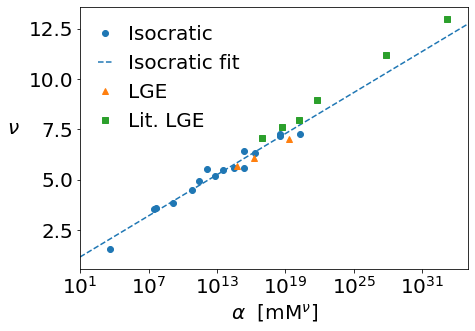

In [68]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'$\alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=15)

a_vals = np.logspace(1, 35, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

ax.plot(df_Keq_nd['a'], -1*df_Keq_nd['b'], 'o', label='Isocratic')
ax.plot(a_vals, -1*np.array(b_vals), linestyle='--', label='Isocratic fit', color=plt.gca().lines[-1].get_color())

ax.plot(df_my_grad_ab['A'], -1*df_my_grad_ab['B'], '^', label='LGE')
ax.plot(df_saleh_ab['A'], -1*df_saleh_ab['B'], 's', label='Lit. LGE')

ax.set_xscale('log')
ax.legend(loc='upper left', frameon=False, handlelength=0.7)
plt.tight_layout()

ax.set_xlim(min(a_vals), max(a_vals))
# fig.savefig('./images/manuscript_images/lge_comparison.pdf')
fig.savefig('./images/manuscript_images/lge_comparison.png', dpi=300)

# Save LGE SDM parameters

In [74]:
df_my_grad_ab.rename(columns={'A':'alpha'}, inplace=True)
df_my_grad_ab['nu'] = -1.0*df_my_grad_ab['B']
df_my_grad_ab['species'] = 'lysozyme'
df_my_grad_ab['data_set'] = 'mine'
eps_t = 0.897
phi = (1.0 - eps_t)/eps_t
df_my_grad_ab['phi'] = phi
df_my_grad_ab['phi_alpha'] = df_my_grad_ab.alpha * phi

df_saleh_ab.rename(columns={'A':'alpha'}, inplace=True)
df_saleh_ab['nu'] = -1.0*df_saleh_ab['B']
df_saleh_ab['data_set'] = 'saleh'
eps_t = 0.73
phi = (1.0 - eps_t)/eps_t
df_saleh_ab['phi'] = phi
df_saleh_ab['phi_alpha'] = df_saleh_ab.alpha * phi

df = pd.concat([df_my_grad_ab, df_saleh_ab])
df.to_csv('./lit_data/gradient_data.csv', index=False)

In [75]:
df

,pH,alpha,B,nu,species,data_set,phi_alpha,phi
0,5.0,2.180305e+19,-6.993300,6.993300,lysozyme,mine,2.503584e+18,0.114827
1,7.0,1.935552e+16,-6.054840,6.054840,lysozyme,mine,2.222540e+15,0.114827
2,9.0,5.541438e+14,-5.665758,5.665758,lysozyme,mine,6.363078e+13,0.114827
0,5.5,1.482861e+33,-12.982040,12.982040,hmw,saleh,5.484556e+32,0.369863
1,5.5,1.709139e+20,-7.934346,7.934346,monomer,saleh,6.321471e+19,0.369863
2,5.8,6.108992e+27,-11.174040,11.174040,hmw,saleh,2.259490e+27,0.369863
3,5.8,5.329393e+18,-7.587223,7.587223,monomer,saleh,1.971145e+18,0.369863
4,6.1,6.161070e+21,-8.938615,8.938615,hmw,saleh,2.278752e+21,0.369863
5,6.1,8.149163e+16,-7.040453,7.040453,monomer,saleh,3.014074e+16,0.369863
